In [1]:
import numpy as np
import scipy
import scipy.stats
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [2]:
%matplotlib inline

In [3]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [4]:
device=t.device('cpu') #Overrride the above device choice

Generate the sample 2D distribution: uniform from unit circle.

In [5]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)

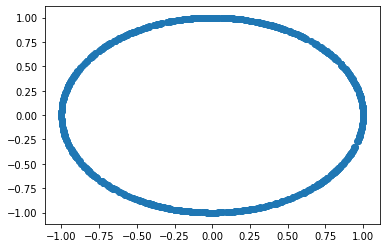

In [6]:
plt.scatter(data[:,0], data[:,1]);

In [7]:
# plt.hist(data)

In [8]:
def makeNet(n_layers, n_neurons_in_last_layer):
    n = n_layers-1
    n_neurons_in_first_layer = n_neurons_in_last_layer*(2**(n-1))
    modules=[]
    modules.append(Linear(in_features=1, out_features=n_neurons_in_first_layer))
    modules.append(LeakyReLU())
    for i in range(n-1):
        modules.append(Linear(in_features=n_neurons_in_first_layer, out_features=n_neurons_in_first_layer//2))
        modules.append(LeakyReLU())
        n_neurons_in_first_layer//=2
    modules.append(Linear(in_features=n_neurons_in_last_layer, out_features=2))
   
    return Sequential(*modules)

In [9]:
data_t = t.from_numpy(data)

In [10]:
data_t

tensor([[ 0.9360,  0.3519],
        [ 0.9071,  0.4209],
        [ 0.9153, -0.4028],
        ...,
        [ 0.9320, -0.3626],
        [-0.8467, -0.5320],
        [-0.8849,  0.4658]])

In [11]:
# discriminator = Sequential(Linear(2,128), LeakyReLU(0.2, inplace=True),
#                            Linear(128,512), LeakyReLU(0.2, inplace=True),
#                            Linear(512,64), LeakyReLU(0.2, inplace=True),
#                            Linear(64,32), LeakyReLU(0.2, inplace=True),
#                            Linear(32,1),  Sigmoid()
#                                      )

In [12]:
discriminator = Sequential(Linear(2,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,32), LeakyReLU(0.2, inplace=True),
                           Linear(32,1),  Sigmoid()
                                     )

In [13]:
discriminator = discriminator.to(device) 
data_t = data_t.to(device)

In [14]:
generator = makeNet(5,32)

In [15]:
d_out = discriminator(data_t)
# plt.hist(d_out.data.cpu().numpy().reshape(-1))

In [16]:
generator= generator.to(device)

In [17]:
out_t = generator(t.empty(1000,1, device=device).uniform_(-np.pi,np.pi));

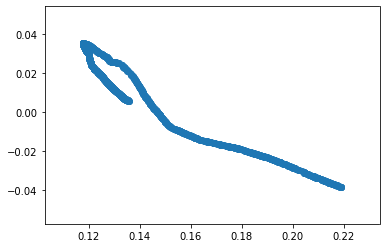

In [18]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [19]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [20]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

In [21]:
bce = t.nn.BCELoss()

In [22]:
mini_batch_size = 32
k_discriminator = 4
k_generator = 1
for epoch in range(1,301):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
          
            d = data_t[kr*mini_batch_size:(kr+1)*mini_batch_size]
            
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
      
            z = t.empty(mini_batch_size,1, device=device).uniform_(-np.pi,np.pi)
            g_out = generator(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
    #to samo dla generatora
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,1, device=device).uniform_(-np.pi,np.pi)
        g_out = generator(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%5 == 0:
        with t.no_grad():
                z = t.empty(len(data_t),1, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t),1, device=device)
                fake_labels = t.zeros(len(data_t),1, device=device)
                g_out =  generator(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                
                print(epoch, d_loss.item(), g_loss.item())     

5 0.7281516194343567 1.52949857711792
10 0.7338667511940002 1.5876781940460205
15 1.7633945941925049 0.6868108510971069
20 1.5506879091262817 0.653462290763855
25 1.4380850791931152 0.7653728723526001
30 1.3512709140777588 0.8498783111572266
35 1.4171156883239746 0.7711167335510254
40 1.4113550186157227 0.7864259481430054
45 1.3381638526916504 0.8667354583740234
50 1.37120521068573 0.840758740901947
55 1.3506968021392822 0.8534007668495178
60 1.4026671648025513 0.7849216461181641
65 1.449021816253662 0.7259364128112793
70 1.457993507385254 0.7319539785385132
75 1.3871212005615234 0.8008167147636414
80 1.3757030963897705 0.8156605362892151
85 1.3430590629577637 0.8431705236434937
90 1.354702115058899 0.85167396068573
95 1.489809513092041 0.6817194819450378
100 1.4961166381835938 0.68321293592453
105 1.4226012229919434 0.7558437585830688
110 1.3328800201416016 0.8872663378715515
115 1.430138349533081 0.7486762404441833
120 1.3885763883590698 0.8198486566543579
125 1.365707516670227 0.841

In [23]:
out_t = generator(t.empty(1000,1, device=device).uniform_(-np.pi,np.pi));

In [24]:
# plt.hist(out_t.data.cpu().numpy().reshape(-1))

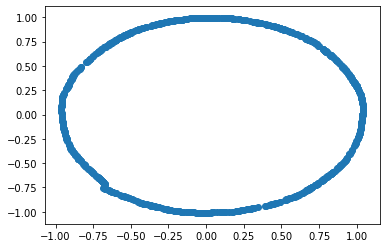

In [25]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.

Update to Pegaz both the notebook and the trained generator.

### Problem 2

Use sampling distribution below.

In [83]:
n_samples = 10000
a = 2
b = 1
angle2 = np.random.uniform(-np.pi,np.pi,(n_samples,1)).astype('float32')
r = np.sqrt(np.random.uniform(0.5,1,(n_samples,1)))
data2 = np.stack((a*r*np.cos(3*angle2), b*r*np.sin(2*angle2)),axis=1)

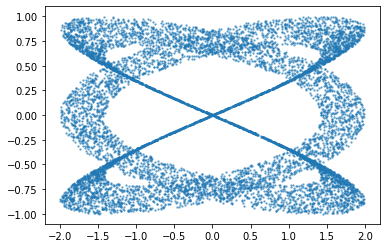

In [84]:
plt.scatter(data2[:,0], data2[:,1], s=2, alpha=0.5);

Update to Pegaz both the notebook and the trained generator.

In [85]:
data2 = np.concatenate((data2[:,0], data2[:,1]),axis=1)

([array([1008., 1457.,  934.,  802.,  756.,  745.,  809.,  943., 1458.,
         1088.]),
  array([   0.,    0., 1039., 2458., 1538., 1540., 2359., 1066.,    0.,
            0.])],
 array([-1.99822671, -1.59917796, -1.20012922, -0.80108047, -0.40203173,
        -0.00298298,  0.39606576,  0.79511451,  1.19416325,  1.593212  ,
         1.99226074]),
 <a list of 2 Lists of Patches objects>)

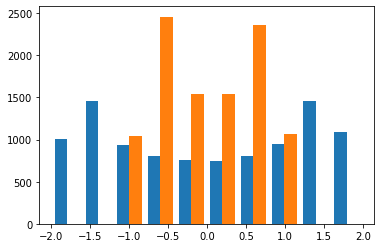

In [86]:
plt.hist(data2)

In [87]:
def makeNet(n_layers, n_neurons_in_last_layer):
    n = n_layers-1
    n_neurons_in_first_layer = n_neurons_in_last_layer*(2**(n-1))
    modules=[]
    modules.append(Linear(in_features=3, out_features=n_neurons_in_first_layer)) 
    modules.append(LeakyReLU())
    for i in range(n-1):
        modules.append(Linear(in_features=n_neurons_in_first_layer, out_features=n_neurons_in_first_layer//2))
        modules.append(LeakyReLU())
        n_neurons_in_first_layer//=2
    modules.append(Linear(in_features=n_neurons_in_last_layer, out_features=2))
   
    return Sequential(*modules)

In [88]:
data_t2 = t.Tensor(data2)
data_t2

tensor([[-1.0650, -0.9700],
        [ 0.7545, -0.8394],
        [-1.3736,  0.2903],
        ...,
        [ 1.4931, -0.5645],
        [-0.4353,  0.8364],
        [-1.7461,  0.8099]])

In [89]:
discriminator = Sequential(Linear(2,128), LeakyReLU(0.2, inplace=True),
                           Linear(128,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,64), LeakyReLU(0.2, inplace=True),
                           Linear(64,32), LeakyReLU(0.2, inplace=True),
                           Linear(32,1),  Sigmoid()
                                     )

In [90]:
discriminator = discriminator.to(device) 
data_t2 = data_t2.to(device)

In [91]:
generator2 = makeNet(5,32)

In [92]:
d_out = discriminator(data_t2)
# plt.hist(d_out.data.cpu().numpy().reshape(-1))

In [93]:
generator2= generator2.to(device)

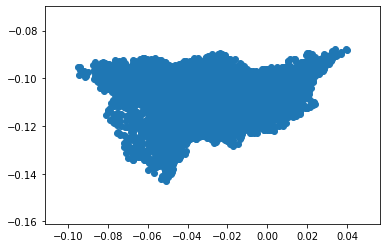

In [94]:
out_t = generator2(t.empty(n_samples,3, device=device).uniform_(-np.pi,np.pi));
plt.scatter(out_t.data.cpu().numpy()[:,0], out_t.data.cpu().numpy()[:,1])

In [95]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = t.optim.Adam(generator2.parameters(), lr=0.0002)

In [96]:
mini_batch_size = 32
k_discriminator = 4
k_generator = 1
for epoch in range(1,301):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
          
            d = data_t2[kr*mini_batch_size:(kr+1)*mini_batch_size]
            
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
      
            z = t.empty(mini_batch_size,3, device=device).uniform_(-np.pi,np.pi)
            g_out = generator2(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
    #to samo dla generatora
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,3, device=device).uniform_(-np.pi,np.pi)
        g_out = generator2(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%5 == 0:
        with t.no_grad():
                z = t.empty(len(data_t2),3, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t2),1, device=device)
                fake_labels = t.zeros(len(data_t2),1, device=device)
                g_out =  generator2(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t2), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                
                print(epoch, d_loss.item(), g_loss.item())     

5 0.873757004737854 1.6380698680877686
10 1.3115378618240356 0.9050912261009216
15 1.2907921075820923 0.9516810774803162
20 1.191222906112671 1.1361324787139893
25 1.6451599597930908 0.5976355671882629
30 1.0812811851501465 1.4990875720977783
35 1.3918691873550415 0.7670300602912903
40 1.2793715000152588 0.94512540102005
45 1.233005166053772 1.0725595951080322
50 1.2244912385940552 0.9496204853057861
55 1.2051541805267334 1.076907992362976
60 1.1868181228637695 1.0434811115264893
65 1.4325484037399292 0.8019633293151855
70 1.380486249923706 0.8235990405082703
75 1.3069454431533813 0.8881869912147522
80 1.4587620496749878 0.8157633543014526
85 1.4632151126861572 0.7049219012260437
90 1.1441574096679688 1.1290967464447021
95 1.3293497562408447 1.058919906616211
100 1.526603102684021 0.6640530824661255
105 1.4248461723327637 0.7799112200737
110 1.3824681043624878 0.8900629878044128
115 1.5658183097839355 0.6462940573692322
120 1.3109241724014282 0.8788949251174927
125 1.4639111757278442 0

In [97]:
out_t = generator2(t.empty(n_samples,3, device=device).uniform_(-np.pi,np.pi));

(array([1330., 1251., 2246., 3049., 2596., 2100., 3201., 1581., 1402.,
        1244.]),
 array([-1.9445359 , -1.5483265 , -1.1521171 , -0.75590783, -0.35969847,
         0.03651088,  0.43272024,  0.8289296 ,  1.2251389 ,  1.6213483 ,
         2.0175576 ], dtype=float32),
 <a list of 10 Patch objects>)

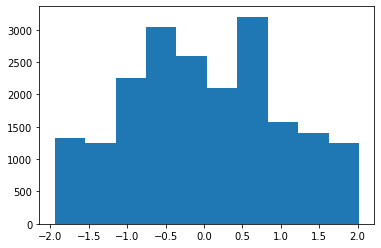

In [98]:
plt.hist(out_t.data.cpu().numpy().reshape(-1))

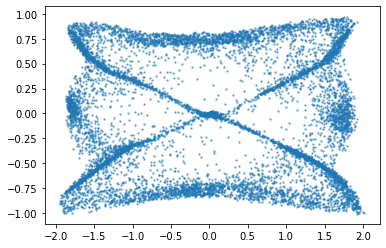

In [99]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1], s=2, alpha=0.5)